# Explorations into the Finite Element Method
## Carter Rhea
### April 14, 2016 - April 28, 2016

# Main test case: 
$$-u''(x)+q(x)u(x)=f(x) $$

In order to use the weak form of the ODE we must first employ the "Method of Weighted Residuals". The residual for our case is simply: $$R(x) = -u''(x)+q(x)u(x)-f(x) $$
Thus to complete the method of weighted residuals we have
$$\int{w(x)R(x)}=\int{w(x)\big(-u''(x)+q(x)u(x)-f(x)}\big) $$
Note that through integration by parts: $$\int{-w(x)\frac{d^2u}{d^2x}} = \int{\frac{dw}{dx}\frac{du}{dx}}dx-\int{w(x)\frac{du}{dx}}d \Gamma $$
where the $d \Gamma$ integral refers to the boundary condition.


Thus plugging in we get, 
$$\int{\frac{dw}{dx}\frac{du}{dx}+q(x)w(x)u(x) dx} = \int{f(x)w(x)dx}+\int{w(x)\frac{du}{dx}d \Gamma} $$

Now we must make the leap and approximate our solution $u(x)$ as 
$$u_{app} = \sum_{j=1}^n U_jS_j(x) $$
where $S_j(x)=\delta_{ij}$
Substituting this in we get, 
$$\int{\frac{dw}{dx}\sum_{j=1}^n U_jS_j(x)+q(x)w(x)\sum_{j=1}^n U_jS_j(x) dx} = \int{f(x)w(x)dx}+\int{wSVd\Gamma} $$
where SV refers to the boundary values.

$$\sum_{j=1}^n\Big( \int  { \frac{dw}{dx} \frac{dS_j(x)}{du} + q(x)w(x)S_j(x)dx }\Big) U_j = \int{f(x)w(x)dx}+\int{w(x)SVd\Gamma}$$
In other notation,
$$[K]\{U\}=\{F\}+\{B\}$$
where K is the stiffness matrix.
Since we are using the Galerkin method $w(x)=S_i$

$$K_{ij} = \int{\frac{dS_i}{dx}\frac{dS_j}{dx}+q(x)S_iS_jdx} $$
$$F_{i} = \int{f(x)S_idx} $$
$$B \rightarrow Boundary $$

For our $S_j(x)=\delta_{ij}$ we examine one element to see our change of coordinates.

Here is our initial element using the "hats" - kronecker delta. The first image is a pre-transformation image and the final image is post-transformation 

<img src="445_final_base_element.pdf">

<img src="445_final_trans.pdf">

Hence $S_1 = \frac{1}{2}(1-\xi)$ and $S_2 = \frac{1}{2}(1+\xi)$ which correlates to a transformation of 
$$x = \frac{h^e}{2}\xi +\frac{x_1^e+x_2^e}{2} $$ 
where $h^e = x_2^e-x_1^e$

Therefore, with our coordinate change, we can rewrite our stiffness matrix noting that $\frac{dS}{dx}=\frac{dS}{d\xi}\frac{d\xi}{dx} $
$$K_{ij}=\int_{-1}^1{\Big(\big(\frac{dS_i}{d\xi}\frac{d\xi}{dx}\big) \big(\frac{dS_j}{d\xi}\frac{d\xi}{dx}\big) + qS_iS_j\Big)}\frac{dx}{d\xi} d\xi$$

It is worth nothing that $$\frac{dx}{d\xi} = \frac{h^e}{2}=J^e$$

Thus we have,
$$K_{ij}=\int_{-1}^1{\Big(\big(\frac{dS_i}{d\xi}\frac{1}{J^e}\big) \big(\frac{dS_j}{d\xi}\frac{1}{J^e}\big) + qS_iS_j\Big)}J^e d\xi$$

And $$F_I^e = \int_{-1}^1{S_i \ f(\xi)J^e d \xi} $$

Since we only have 2 $S$ equations we need to calculate only $K_{11},K_{12},K_{21},K_{22}$ and $F_1,F_2$ and then assemble the matrix based on them, created a tridiagonal matrix!

In [1]:
import numpy as np
import scipy.misc
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline
from FEM import Stiff,F

## Test Case:
 For a test case I will be solving the equation $$-y'' + y = sin(ax), \  t\in (0,\pi)$$
 both analytically and numerically in order to asses errors.

## Numerical Solving

In [2]:
n_elements = 100
s_elements = 2
start = 0
end = 2*np.pi
q = 1
a = 1
B_init = np.zeros(n_elements)
B_start = np.sin(a*start)
B_end = np.sin(a*end)
B_init[0] = B_start
B_init[-1] = B_end

def S_i(x):
    return (1/2)*(1-x)

def S_j(x):
    return (1/2)*(1+x)
    
def K(S_i,S_j,dS_i,dS_j,q,J,x):
    return ((dS_i/J)*(dS_j/J)+q*S_i*S_j)*J

def f(x):
    return np.sin(a*x)

In [3]:
spacing = np.linspace(start,end,n_elements)

In [4]:
K_matrix = Stiff(K,S_i,S_j,q,n_elements,s_elements,start,end);
F_matrix = F(f,S_i,S_j,n_elements,s_elements,start,end);
B_matrix = B_init

In [5]:
K_matrix

array([[ 31.87287652, -15.90502233,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [-15.90502233,  31.87287652, -15.90502233, ...,   0.        ,
          0.        ,   0.        ],
       [  0.        , -15.90502233,  31.87287652, ...,   0.        ,
          0.        ,   0.        ],
       ..., 
       [  0.        ,   0.        ,   0.        , ...,  31.87287652,
        -15.90502233,   0.        ],
       [  0.        ,   0.        ,   0.        , ..., -15.90502233,
         31.87287652, -15.90502233],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
        -15.90502233,  31.87287652]])

### Solving the matrix via my software

In [6]:
from FEM import LUalgobanded, solveUnitLowerTriangularbanded, solveUnitUpperTriangularbanded

Since we know the boundary conditions, we can nix the initial and final row/column.
So keep in mind that with our example we let the boundary conditions be such that the $x_{initial}=0$ and $x_{final}=0$.

In [7]:
L_stiff,U_stiff = LUalgobanded(K_matrix,1)

In [8]:
C_stiff = solveUnitLowerTriangularbanded(L_stiff,F_matrix,1)

In [9]:
Sol_stiff = np.zeros(n_elements)
Sol_stiff = solveUnitUpperTriangularbanded(U_stiff,C_stiff,1)

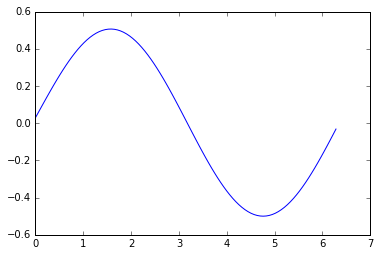

In [10]:
plt.plot(spacing,Sol_stiff)

### Solve with Scipy.linalg.solve

In [11]:
Scipy_sol = sp.linalg.solve(K_matrix,F_matrix+B_matrix)

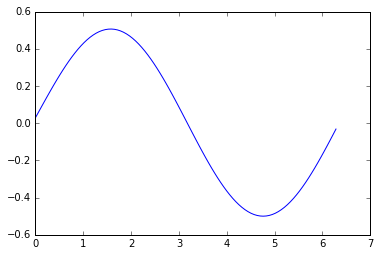

In [12]:
plt.plot(spacing,Scipy_sol)

### Exact Solution

Let's quickly find the exact solution.
$$y''+y=sin(ax)$$
So my guess is $y=Asin(ax) \rightarrow y''=-Aa^2sin(ax)$
Hence plugging in we get,
$$Aa^2sin(ax)+Asin(ax)=sin(x)$$

$$A = \frac{1}{1+a^2} $$
Therefore,
$$y=\frac{1}{1+a^2}sin(ax)$$

In [13]:
exact = lambda x: (1/(1+a**2))*np.sin(a*x)
exact_val = np.zeros(n_elements)
for i in range(n_elements):
    exact_val[i] = exact(spacing[i])

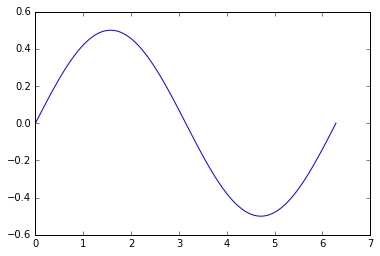

In [14]:
plt.plot(spacing,exact_val)

## Errors:
We are going to check the errors comparing the exact solution to the scipy solving software and my banded algo software.

In [15]:
exact_vs_banded_error_max = sp.linalg.norm(exact_val-Sol_stiff,np.inf)
exact_vs_scipy_error_max = sp.linalg.norm(exact_val-Scipy_sol,np.inf)
print("The maximum error between the exact solution and my banded algorithm solution is %s"%exact_vs_banded_error_max)
print("The maximum error between the exact solution and the scipy algorithm solution is %s"%exact_vs_scipy_error_max)

The maximum error between the exact solution and my banded algorithm solution is 0.031471016971
The maximum error between the exact solution and the scipy algorithm solution is 0.031471016971


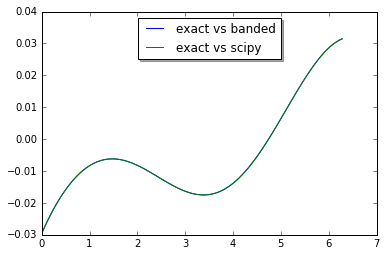

In [16]:
exact_vs_banded_line = plt.plot(spacing,exact_val-Sol_stiff,label="exact vs banded")
exact_vs_scipy_line = plt.plot(spacing,exact_val-Scipy_sol,label="exact vs scipy")
legend = plt.legend(loc='upper center', shadow=True)

Hence we can say that my banded software is doing essentially the same as scipy's built in software. More importantly, my Finite Element Method code is functioning properly. For furter test cases I will just be using scipy software to solve the matrix equation.

And now lets see if the error truly follows the $O(h^2)$ decrease that we are supposed to see...

In [17]:
for n_el in [100,200,400]:
    spacing = np.linspace(start,end,n_el)
    K_matrix = Stiff(K,S_i,S_j,q,n_el,s_elements,start,end);
    F_matrix = F(f,S_i,S_j,n_el,s_elements,start,end);
    Scipy_sol = sp.linalg.solve(K_matrix,F_matrix)
    exact_val = np.zeros(n_el)
    for i in range(n_el):
        exact_val[i] = exact(spacing[i])
    err = sp.linalg.norm(exact_val-Scipy_sol,np.inf)
    print("The max error for n= %s is %s"%(n_el,err))

The max error for n= 100 is 0.031471016971
The max error for n= 200 is 0.0157142504092
The max error for n= 400 is 0.00785455742262


The error is approximately being halved everytime we half h so we are seeing an error of approxiamtely O(h).

# Next Main Test Form:
$$-u''+p(x)u'+q(x)u=f(x) $$

To start solving lets first let $A(x)=e^{-\int{p(x)}dx}$.

Thus multiplying our test equation by $A$ we get,
$$-A(x)u''+A(x)p(x)u'+A(x)q(x)u=A(x)f(x) $$
Since $Au''+A(x)p(x)u' = A(x)u'$ by the chain rule, we can fix up our equation to:
$$-\big(A(x)u'\big)'+Q(x)u=F(x) $$ 
where $Q(x) = A(x)q(x)$ and $F(x) = A(x)f(x)$
 
Once again using the "Method of Weighted Residuals" in order to obtain the Weak Form of the ODE...
$$\int{-w(x)\big(A(x)u'\big)'+w(x)Q(x)u}=\int{w(x)F(x)} $$
It is certainly worth noting that $$\int{-w(x)\big(A(x)u'\big)'}=\int{\frac{dw}{dx}A(x)u'dx}-\int{w(x)A(x)u'd\Gamma}$$
where $d\Gamma$ just represents our boundary.
Now everything proceeds like the previous example:
$$\int{A(x)\frac{dw}{dx}\frac{du}{dx}+Q(x)w(x)u(x) dx} = \int{F(x)w(x)dx}+\int{A(x)w(x)\frac{du}{dx}d \Gamma} $$


Now we must make the leap and approximate our solution $u(x)$ as 
$$u_{app} = \sum_{j=1}^n U_jS_j(x) $$
where $S_j(x)=\delta_{ij}$
Substituting this in we get, 
$$\int{A(x)\frac{dw}{dx}\sum_{j=1}^n U_jS_j(x)+Q(x)w(x)\sum_{j=1}^n U_jS_j(x) dx} = \int{F(x)w(x)dx}+\int{A(x)w(x)SVd\Gamma} $$
where SV refers to the boundary values.

$$\sum_{j=1}^n\Big( \int  {A(x) \frac{dw}{dx} \frac{dS_j(x)}{du} + Q(x)w(x)S_j(x)dx }\Big) U_j = \int{F(x)w(x)dx}+\int{A(x)w(x)SVd\Gamma}$$
In other notation,
$$[K]\{U\}=\{F\}+\{B\}$$
where K is the stiffness matrix.
Since we are using the Galerkin method $w(x)=S_i$

$$K_{ij} = \int{A(x)\frac{dS_i}{dx}\frac{dS_j}{dx}+Q(x)S_iS_jdx} $$
$$F_{i} = \int{F(x)S_idx} $$
$$B \rightarrow Boundary $$

Using the same hat functions as before the transformation follows in the same exact manner...
Hence, 
 $$K_{ij}=\int_{-1}^1{\Big(A(x)\big(\frac{dS_i}{d\xi}\frac{1}{J^e}\big) \big(\frac{dS_j}{d\xi}\frac{1}{J^e}\big) + Q(x)S_iS_j\Big)}J^e d\xi$$
And $$F_I^e = \int_{-1}^1{S_i \ F(\xi)J^e d \xi} $$

In [18]:
n_elements = 100
s_elements = 2
start = 0
end = 2*np.pi
def A(x): return x
def Q(x): return 2
B_init = np.zeros(n_elements)
B_start = np.sin(a*start)
B_end = np.sin(a*end)
B_init[0] = B_start
B_init[-1] = B_end

def S_i(x):
    return (1/2)*(1-x)

def S_j(x):
    return (1/2)*(1+x)
    
def K(S_i,S_j,dS_i,dS_j,q,J,x):
    return ((A(x)*dS_i/J)*(dS_j/J)+Q(x)*S_i*S_j)*J

def f(x):
    return x**2

In [19]:
spacing = np.linspace(start,end,n_elements)
K_matrix = Stiff(K,S_i,S_j,q,n_elements,s_elements,start,end);
F_matrix = F(f,S_i,S_j,n_elements,s_elements,start,end);
Scipy_sol = sp.linalg.solve(K_matrix,F_matrix)

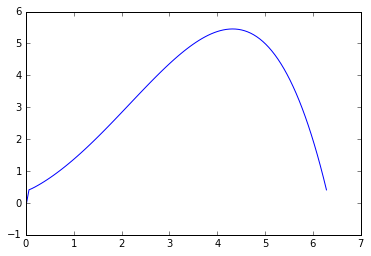

In [20]:
plt.plot(spacing,Scipy_sol)